<a href="https://colab.research.google.com/github/i-am-adithyavardhan/MiniProject_3rdYear/blob/main/bertCombinedHasocFinal.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 49.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 23.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 89.5 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, f1_score, classification_report,accuracy_score

import matplotlib.pyplot as plt

import torch 
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, TensorDataset
from torch.utils.data import DataLoader,RandomSampler,SequentialSampler

from transformers import BertTokenizer, BertForSequenceClassification
from transformers import AdamW
from transformers import get_linear_schedule_with_warmup

# import warnings
# warnings.filterwarnings("ignore")

In [ ]:
filePath = '/content/drive/MyDrive/HasocDataset/hindi_2021.csv'
df1 = pd.read_csv(filePath,delimiter=',')
df1 = df1.drop('task_2',axis=1)
df1.columns = ['ID','TwitterID','HASOCID','Text','Type']
df1 = df1.drop(['ID','TwitterID','HASOCID'],axis=1)

filePath = '/content/drive/MyDrive/HasocDataset/hindi_2020.xlsx'
df2 = pd.read_excel(filePath)
df2 = df2.drop(['tweet_id','task2','ID'],axis=1)
df2.columns = ['Text','Type']

filePath = '/content/drive/MyDrive/HasocDataset/hindi_2019_1.tsv'
df3 = pd.read_csv(filePath,delimiter='\t')
df3 = df3.drop(['text_id','task_2','task_3'],axis=1)
df3.columns = ['Text','Type']

filePath = '/content/drive/MyDrive/HasocDataset/hindi_2019_2.tsv'
df4 = pd.read_csv(filePath,delimiter='\t')
df4 = df4.drop(['text_id','task_2','task_3'],axis=1)
df4.columns = ['Text','Type']

In [ ]:
df2.head

<bound method NDFrame.head of                                                    Text Type
0     1 आदमीं को मारने पर गोडसे आतंकी हो सके है तो\n...  HOF
1     RT @Vishesh4: @jawaharyadavbjp जवाहर यादव, अगर...  NOT
2     RT @FunKeyBaat: #भगवा वस्त्र पहन कर मतदान नही ...  HOF
3     Yey nina khothani labafazi benu phambili Finis...  HOF
4     RT @Rajeshbhanjan2: जब भी कोई सिकुलर कोंग्रेसी...  HOF
...                                                 ...  ...
2958  @Varun_dvn जिसके नाम के साथ इंडिअनस लगा हो उसक...  NOT
2959  मुझे सबसे ज्यादा राहुल और सोनियाके बारे बुरा ल...  NOT
2960  RT @Gujju_Er: एक आतंकी जिसे कांग्रेस ने\n'शांत...  HOF
2961  RT @dayanand151: @jafahar1 @BBCHindi @Hariramk...  HOF
2962  RT @manakgupta: “हमें 5 साल हो गए, हमने संविधा...  NOT

[2963 rows x 2 columns]>

In [ ]:
print(df1['Type'].value_counts()['HOF'])
print(df1['Type'].value_counts()['NOT'])
print(df1.shape)
print("--df2")
print(df2['Type'].value_counts()['HOF'])
print(df2['Type'].value_counts()['NOT'])
print(df2.shape)

1433
3161
(4594, 2)
--df2
847
2116
(2963, 2)


In [ ]:
df = pd.concat([df1,df2,df3,df4])
df.head()

,Text,Type
0,@rssurjewala #Hindus DYING #HindusLivesMatter ...,NOT
1,सब लोग इतने पैसे डोनेट ही कर रहे हैं फिर भी आम...,NOT
2,शेर-ए- सिवान शहाबुद्दीन साहब से रिश्ता क्या ل...,NOT
3,@AskAnshul आसमानी किताब के नाजायज औलाद है।,HOF
4,@Shikha0222 इसे कहते हैं दोगला पंती जिस सपा की...,NOT


In [ ]:
df['Type'] = df['Type'].astype('category')
df['Type'] = df['Type'].cat.codes
df['Type'] = df['Type'].astype(np.int64)
df.head()

,Text,Type
0,@rssurjewala #Hindus DYING #HindusLivesMatter ...,1
1,सब लोग इतने पैसे डोनेट ही कर रहे हैं फिर भी आम...,1
2,शेर-ए- सिवान शहाबुद्दीन साहब से रिश्ता क्या ل...,1
3,@AskAnshul आसमानी किताब के नाजायज औलाद है।,0
4,@Shikha0222 इसे कहते हैं दोगला पंती जिस सपा की...,1


In [ ]:
data = df.copy()

In [ ]:
import re

In [ ]:
USERNAME_PATTERN = r'@([A-Za-z0-9_]+)' 
PUNCTUATION_PATTERN = '\'’|!@$%^&*()_+<>?:.,;-' 

In [ ]:
stopwords_hindi_file = pd.read_csv('/content/drive/MyDrive/HasocDataset/stopwords-hi.txt',header=None) # hindi stop words.

In [ ]:
def remove_punctuations(text):
  return "".join([c for c in text if c not in PUNCTUATION_PATTERN])

def remove_stopwords(text):
  return " ".join([word for word in text.split() if word not in stopwords_hindi_file])

def remove_usernames(text):
  return re.sub(USERNAME_PATTERN, '', text)

In [ ]:
data['clean_text'] = data['Text'].apply(remove_usernames)# removing usernames
data['clean_text'] = data['clean_text'].apply(remove_punctuations)# removing punctuations
data['clean_text'] = data['clean_text'].apply(remove_stopwords) # removing stopwords

In [ ]:
data = data.drop(['Text'],axis = 1)

In [ ]:
data.head

<bound method NDFrame.head of       Type                                         clean_text
0        1  #Hindus DYING #HindusLivesMatter #KindAttnPMNa...
1        1  सब लोग इतने पैसे डोनेट ही कर रहे हैं फिर भी आम...
2        1  शेरए सिवान शहाबुद्दीन साहब से रिश्ता क्या لا إ...
3        0                    आसमानी किताब के नाजायज औलाद है।
4        1  इसे कहते हैं दोगला पंती जिस सपा की दम पर 0 से ...
...    ...                                                ...
4660     1  पाकिस्तान ने हिंदुओं के ख़िलाफ़ बोलने वाले को ...
4661     0  कोहली है #नेहरू नहीं जो अंग्रेजों के तलवे चाटन...
4662     1         परशुराम वही जिसने अपनी मां की हत्या की थीं
4663     0  जिस देश में #कन्हैयाकुमार जैसा पढ़ा लिखा युवा ...
4664     0  इनके बापों मैं भी दम नहीं जो भारत को इस्लामिक ...

[13540 rows x 2 columns]>

In [ ]:
X = list(df['Text'].values)
y = list(df['Type'].values)

Train Validation Test Split

In [ ]:
X_tmp, X_test, y_tmp, y_test = train_test_split(X, y, test_size = 0.10, random_state=42,stratify=y) #80% train 10% test 10% validation
X_train, X_valid, y_train, y_valid = train_test_split(X_tmp, y_tmp, test_size = 0.111, random_state=42,stratify=y_tmp)
#If random_state is None or np.random, then a randomly-initialized RandomState object is returned.
#If random_state is an integer, then it is used to seed a new RandomState object.
#If random_state is a RandomState object, then it is passed through.
print(len(X_train))
print(len(X_valid))
print(len(X_test))

10833
1353
1354


In [ ]:
import operator as op

train_0 = op.countOf(y_train,0)
train_1 = op.countOf(y_train,1)
val_0 = op.countOf(y_valid,0)
val_1 = op.countOf(y_valid,1)
test_0 = op.countOf(y_test,0)
test_1 = op.countOf(y_test,1)

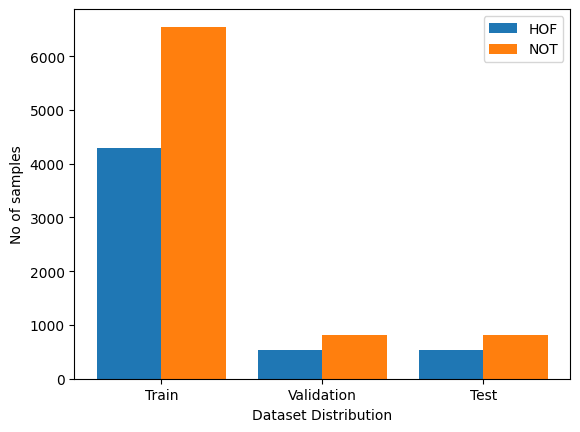

In [ ]:
import numpy as np 
import matplotlib.pyplot as plt 
  
X = ['Train','Validation','Test']
hateLabels = [train_0,val_0,test_0]
notLabels = [train_1,val_1,test_1]
  
X_axis = np.arange(len(X))
  
plt.bar(X_axis - 0.2, hateLabels, 0.4, label = 'HOF')
plt.bar(X_axis + 0.2, notLabels, 0.4, label = 'NOT')
  
plt.xticks(X_axis, X)
plt.xlabel("Dataset Distribution")
plt.ylabel("No of samples")
plt.legend()
plt.show()

Model

In [ ]:
model_name = 'bert-base-multilingual-cased'

In [ ]:
def generate_dataset(X,y, tokenizer):
  #Generate encodings
  encodings = tokenizer.batch_encode_plus(X,truncation = True,padding=True,max_length=128,return_tensors='pt',add_special_tokens = True)

  #convert to tensor dataset
  input_ids = encodings['input_ids']
  attention_mask = encodings['attention_mask']

  input_ids = torch.tensor(input_ids)
  attention_mask = torch.tensor(attention_mask)
  y = torch.tensor(y)

  dataset = TensorDataset(input_ids,attention_mask,y)

  return dataset

In [ ]:
tokenizer = BertTokenizer.from_pretrained(model_name)

In [ ]:
train_dataset = generate_dataset(X_train,y_train,tokenizer)
valid_dataset = generate_dataset(X_valid,y_valid,tokenizer)

<ipython-input-9-9c3d998b3cdd>:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  input_ids = torch.tensor(input_ids)
<ipython-input-9-9c3d998b3cdd>:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  attention_mask = torch.tensor(attention_mask)


In [ ]:
def get_data_loader(dataset,sampler):
  return DataLoader(dataset=dataset,sampler=sampler(dataset),batch_size=32)

In [ ]:
train_loader = get_data_loader(train_dataset,RandomSampler)
validation_loader = get_data_loader(valid_dataset,SequentialSampler)

Importing Model

In [ ]:
model = BertForSequenceClassification.from_pretrained(model_name, num_labels=2)
model.cuda()

Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model ch

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(119547, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12

Optimizer

In [ ]:
optimizer = torch.optim.AdamW(model.parameters(),lr=2e-5,eps=1e-8)

num_epochs = 8
total_steps = len(train_loader) * num_epochs

scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps = 0, num_training_steps = total_steps)

In [ ]:
def compute_accuracy(preds,labels):
  preds = preds.detach().cpu().numpy()
  labels = labels.detach().cpu().numpy()
  preds = np.argmax(preds,axis=1).flatten()
  labels = labels.flatten()
  return np.sum(preds == labels)/len(labels)

In [ ]:
import random
seed_val = 42

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

Function for Training on Training Data

In [ ]:
def train():
  total_loss = 0.0
  total_acc = 0.0

  model.train()
  
  num_steps = 0

  for step,batch in enumerate(train_loader):
    
    if step % 50 == 0 and not step == 0:
      print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(train_loader)))

    input_ids = batch[0].to(device)
    attention_mask = batch[1].to(device)
    labels = batch[2].to(device)

    model.zero_grad()

    outputs = model(input_ids,attention_mask = attention_mask,labels = labels.long())
    
    loss = outputs.loss
    logits = outputs.logits

    total_loss = total_loss + loss.item()
    total_acc = total_acc + compute_accuracy(logits,labels)

    loss.backward()

    torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

    optimizer.step()
    scheduler.step()

  avg_loss = total_loss/len(train_loader)
  avg_acc = total_acc/len(train_loader)

  return avg_loss,avg_acc

Function for training on Validation Data

In [ ]:
def evaluate():
  total_loss = 0.0
  total_acc = 0.0

  model.train()
  
  true_labels = []
  predictions = []

  for step,batch in enumerate(validation_loader):
    
    if step % 50 == 0 and not step == 0:
      print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(validation_loader)))

    input_ids = batch[0].to(device)
    attention_mask = batch[1].to(device)
    labels = batch[2].to(device)

    with torch.no_grad():
      outputs = model(input_ids,attention_mask = attention_mask,labels = labels.long())
    
    loss = outputs.loss
    logits = outputs.logits

    total_loss = total_loss + loss.item()
    total_acc = total_acc + compute_accuracy(logits,labels)

    logits = logits.detach().cpu().numpy()
    logits = np.argmax(logits,axis=1).flatten()
    labels = labels.detach().cpu().numpy().flatten()

    true_labels.extend(labels)
    predictions.extend(logits)

  avg_loss = total_loss/len(validation_loader)
  avg_acc = total_acc/len(validation_loader)
  macro_f1_score =  classification_report(true_labels, predictions,output_dict=True)['macro avg']['f1-score']

  return avg_loss,avg_acc,macro_f1_score

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [ ]:
train_losses = []
train_accs = []
valid_losses = []
valid_accs = []

best_f1 = 0.0

for epoch in range(num_epochs):
  print('\n Epoch {:} / {:}'.format(epoch + 1, num_epochs))
  
  train_loss, train_acc = train()
  valid_loss, valid_acc,f1_score = evaluate()

  train_losses.append(train_loss)
  train_accs.append(train_acc)
  valid_losses.append(valid_loss)
  valid_accs.append(valid_acc)

  if f1_score > best_f1:
      best_f1 = f1_score
      torch.save(model,'/content/drive/MyDrive/HasocDataset/Models/hindi_model_bert.pt')


  print(f'\nTraining Accuracy: {train_acc:.3f} | Training Loss: {train_loss:.3f} | Validation Accuracy: {valid_acc:.3f} | Validation Loss: {valid_loss:.3f} | F1 Score: {f1_score:.3f} ')


 Epoch 1 / 8
  Batch    50  of    339.
  Batch   100  of    339.
  Batch   150  of    339.
  Batch   200  of    339.
  Batch   250  of    339.
  Batch   300  of    339.

Training Accuracy: 0.753 | Training Loss: 0.506 | Validation Accuracy: 0.784 | Validation Loss: 0.507 | F1 Score: 0.750 

 Epoch 2 / 8
  Batch    50  of    339.
  Batch   100  of    339.
  Batch   150  of    339.
  Batch   200  of    339.
  Batch   250  of    339.
  Batch   300  of    339.

Training Accuracy: 0.832 | Training Loss: 0.382 | Validation Accuracy: 0.786 | Validation Loss: 0.481 | F1 Score: 0.776 

 Epoch 3 / 8
  Batch    50  of    339.
  Batch   100  of    339.
  Batch   150  of    339.
  Batch   200  of    339.
  Batch   250  of    339.
  Batch   300  of    339.

Training Accuracy: 0.874 | Training Loss: 0.301 | Validation Accuracy: 0.788 | Validation Loss: 0.481 | F1 Score: 0.776 

 Epoch 4 / 8
  Batch    50  of    339.
  Batch   100  of    339.
  Batch   150  of    339.
  Batch   200  of    339.
  Batc

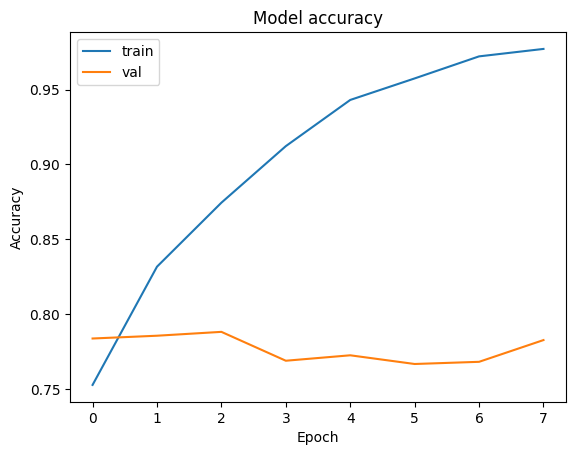

In [ ]:
plt.plot(train_accs)
plt.plot(valid_accs)
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'val'], loc='upper left')

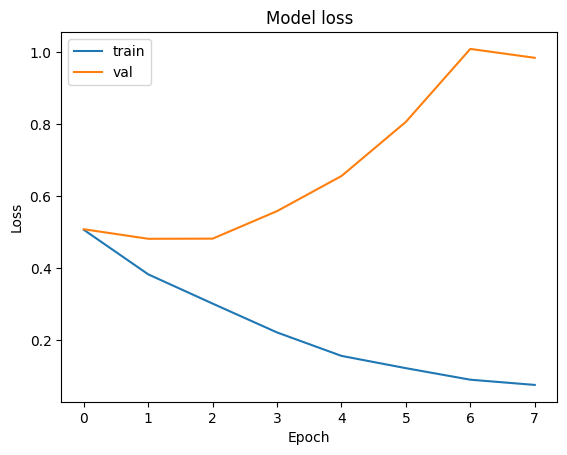

In [ ]:
plt.plot(train_losses)
plt.plot(valid_losses)
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'val'], loc='upper left')

In [ ]:
del model
del train_loader
del validation_loader

import gc
gc.collect()

40

In [ ]:
#category wise accuracy table

In [ ]:
model = torch.load('/content/drive/MyDrive/HasocDataset/Models/hindi_model_bert.pt')
model = model.to(device)

In [ ]:
test_dataset = generate_dataset(X_test,y_test,tokenizer)
test_loader = get_data_loader(test_dataset,SequentialSampler)

<ipython-input-10-9c3d998b3cdd>:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  input_ids = torch.tensor(input_ids)
<ipython-input-10-9c3d998b3cdd>:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  attention_mask = torch.tensor(attention_mask)


In [ ]:
def test_evaluate():
  total_loss = 0.0
  total_acc = 0.0

  model.train()
  
  true_labels = []
  predictions = []

  for step,batch in enumerate(test_loader):
    
    if step % 50 == 0 and not step == 0:
      print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(test_loader)))

    input_ids = batch[0].to(device)
    attention_mask = batch[1].to(device)
    labels = batch[2].to(device)

    with torch.no_grad():
      outputs = model(input_ids,attention_mask = attention_mask,labels = labels.long())
    
    loss = outputs.loss
    logits = outputs.logits

    total_loss = total_loss + loss.item()
    total_acc = total_acc + compute_accuracy(logits,labels)

    logits = logits.detach().cpu().numpy()
    logits = np.argmax(logits,axis=1).flatten()
    labels = labels.detach().cpu().numpy().flatten()

    true_labels.extend(labels)
    predictions.extend(logits)

  avg_loss = total_loss/len(test_loader)
  avg_acc = total_acc/len(test_loader)
  macro_f1_score =  classification_report(true_labels, predictions,output_dict=True)['macro avg']['f1-score']

  return avg_loss,avg_acc,macro_f1_score,true_labels,predictions

In [ ]:
test_loss,test_acc,f1_score,tr,pr = test_evaluate()
print(f'\nTest Accuracy: {test_acc:.3f} | Test Loss: {test_loss:.3f} | F1 Score: {f1_score:.3f} ')


Test Accuracy: 0.810 | Test Loss: 0.401 | F1 Score: 0.807 


In [ ]:
print(tr)
print(pr)

[0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report

In [ ]:
print("Classification Report: \n", classification_report(tr, pr))

Classification Report: 
               precision    recall  f1-score   support

           0       0.76      0.78      0.77       535
           1       0.85      0.84      0.85       819

    accuracy                           0.81      1354
   macro avg       0.81      0.81      0.81      1354
weighted avg       0.82      0.81      0.81      1354



In [ ]:
cf_mat = confusion_matrix(tr,pr)
print("Confusion Matrix: \n", cf_mat)

Confusion Matrix: 
 [[416 119]
 [132 687]]


<Axes: >

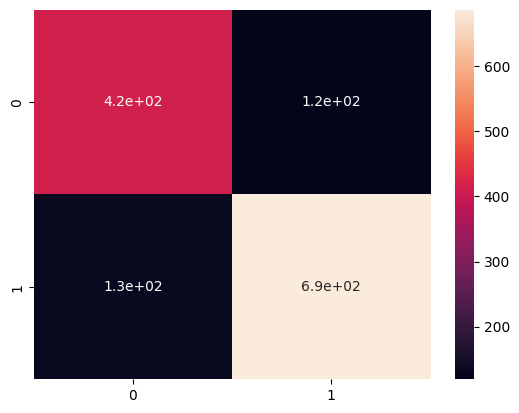

In [ ]:
import seaborn as sns
sns.heatmap(cf_mat, annot=True)

<Axes: >

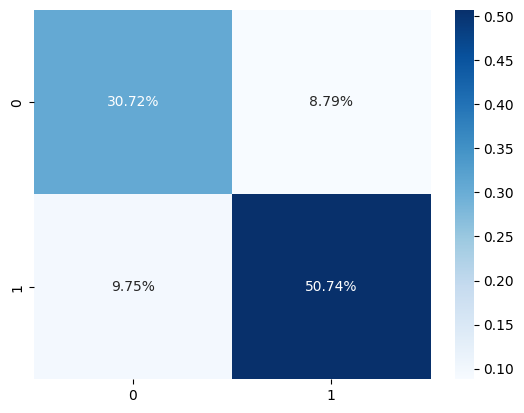

In [ ]:
sns.heatmap(cf_mat/np.sum(cf_mat), annot=True,
            fmt='.2%', cmap='Blues')

<Axes: >

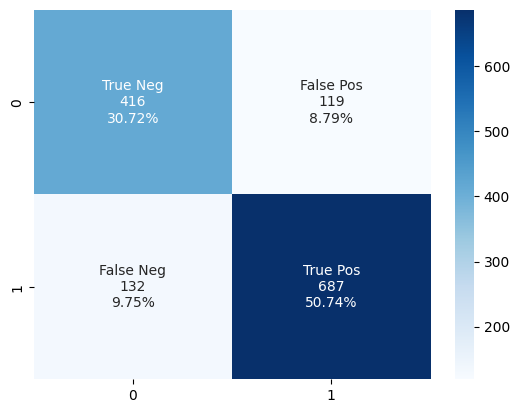

In [ ]:
group_names = ["True Neg","False Pos","False Neg","True Pos"]
group_counts = ["{0:0.0f}".format(value) for value in
                cf_mat.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in
                     cf_mat.flatten()/np.sum(cf_mat)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cf_mat, annot=labels, fmt="", cmap='Blues')


Test on unlabelled dataset

In [ ]:
filePath = '/content/drive/MyDrive/HasocDataset/hi_Hasoc2021_test_task1.csv'
df_test = pd.read_csv(filePath,delimiter=',')

In [ ]:
results = {}

for ind in df_test.index:
  txt = df_test['text'][ind]
  id = df_test['_id'][ind]

  encodings = tokenizer.encode_plus(txt,truncation = True,padding=True,max_length=128,return_tensors='pt')

  input_ids = encodings['input_ids']
  attention_mask = encodings['attention_mask']
  input_ids = torch.tensor(input_ids)
  attention_mask = torch.tensor(attention_mask)

  with torch.no_grad():
    input_ids = input_ids.to(device)
    attention_mask = attention_mask.to(device)
    
    outputs = model(input_ids, attention_mask)
    outputs = outputs.logits.detach().cpu().numpy()
    outputs = np.argmax(outputs,axis=1)
    if(outputs[0]==0):
      results[id] = "HOF"
    else:
      results[id] = "NOT"

<ipython-input-45-f415ee9644b8>:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  input_ids = torch.tensor(input_ids)
<ipython-input-45-f415ee9644b8>:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  attention_mask = torch.tensor(attention_mask)


In [ ]:
df_results = pd.DataFrame(list(results.items()))
df_results.columns = ["id","label"]

In [ ]:
df_results.head()

,id,label
0,60c5d7495659ea5e55df0546,HOF
1,60c5d7495659ea5e55df0591,HOF
2,60c5d7495659ea5e55df0622,NOT
3,60c5d7495659ea5e55df0666,NOT
4,60c5d7495659ea5e55df067b,NOT


In [ ]:
df_results.to_csv("/content/drive/MyDrive/HasocDataset/bertfinetuned_hindi.csv",index=False)

In [ ]:
txt1 = "सकारात्मकता फैलाओ" #spread positivity
txt2 = "हरामी" #bastard
encodings = tokenizer.encode_plus(txt1,truncation = True,padding=True,max_length=128,return_tensors='pt')

input_ids = encodings['input_ids']
attention_mask = encodings['attention_mask']
input_ids = torch.tensor(input_ids)
attention_mask = torch.tensor(attention_mask)

with torch.no_grad():
  input_ids = input_ids.to(device)
  attention_mask = attention_mask.to(device)
  
  outputs = model(input_ids, attention_mask)
  outputs = outputs.logits.detach().cpu().numpy()
  print("o: ",outputs)
  outputs = np.argmax(outputs,axis=1)
  print(outputs)

o:  [[-0.3164056   0.47739992]]
[1]


<ipython-input-67-5a94f1cacd6a>:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  input_ids = torch.tensor(input_ids)
<ipython-input-67-5a94f1cacd6a>:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  attention_mask = torch.tensor(attention_mask)
